# **Rodrigo_Mesquita_PB_TP3**
## **Projeto de Bloco: Inteligência Artificial e Machine Learning [24E1_5]**

## 1.Criação das features:Aplicar Análise de Componentes Principais (PCA) para reduzir a dimensionalidade dos conjuntos de dados.

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split


### Analisando o dataset

In [251]:
df = pd.read_csv('/workspaces/Faculdade/Datasets/healthcare-dataset-stroke-data.csv')

In [252]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [253]:
df.drop(columns=['id'], inplace=True)

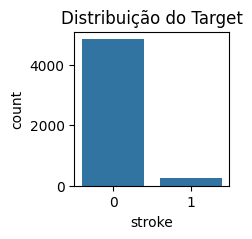

stroke
0    4861
1     249
Name: count, dtype: int64


In [294]:
#Checando a distribuição
plt.figure(figsize=(2,2))
plt.title('Distribuição do Target')
sns.countplot(df, x='stroke')
plt.show()

print(df['stroke'].value_counts())


In [255]:
# O dataset é altamente desbalanceado e apenas 5% das linhas são de paciêntes que tiveram derrame
print('Total de linhas:', df.shape[0])
print('Qtd linhas com Stroke=1:' ,len(df[df['stroke'] == 1]))

Total de linhas: 5110
Qtd linhas com Stroke=1: 249


In [256]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Identificando dados nulos

In [257]:
#Checando se há dados nulos
nulls = df.isnull().sum()
print(nulls)
print('Qtd linhas com Stroke=1:', len(df[df['stroke'] == 1]))
print('Qtd linhas com Stroke=1 e BMI nulo:', len(df[(df['stroke'] == 1) & (df['bmi'].isnull())]))

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
Qtd linhas com Stroke=1: 249
Qtd linhas com Stroke=1 e BMI nulo: 40


In [258]:
# Os nulos representam 16% das pessoas que tiveram derrame, então optei por utilizar o KNNImputer invés de os remover. 
# O apliquei através do Pipeline, junto com as demais normalizações mais abaixo.

### Separando os dados em treino e teste

In [259]:
from sklearn.model_selection import train_test_split

In [260]:
X = df.drop(columns=['stroke'])
Y = df['stroke']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=32)

### Realizando UnderSampling

Eu realizei diversos testes com a base desbalanceada, porém não atingi bons resultados, então escolhi utilizar o método de UnderSampling

In [261]:
!pip install -U imblearn

In [262]:
import imblearn
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority')
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
X_train, Y_train = undersample.fit_resample(X_train, Y_train)

In [296]:
print(Y_train.value_counts())

stroke
0    422
1    211
Name: count, dtype: int64


### Aplicando One-Hot Encoder nas variáveis categóricas, StandartScaler nas numéricas e KNN Imputer na BMI

In [263]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline   import Pipeline
from sklearn.preprocessing   import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

In [264]:
#Listando colunas numéricas e categóricas
col_num = ['age','avg_glucose_level']
col_cat = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type','smoking_status']

#Definindo as transformações que devem ser aplicadas em cada tipo de variável.
pipe_bmi = Pipeline([    
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())    
    ])
pipe_num = Pipeline([    ('scaler', StandardScaler())    ])
pipe_car = Pipeline([    ('encoder', OneHotEncoder(handle_unknown='ignore'))     ])

#Informando as colunas em que as transformações devem ser executadas
preproc_pipeline_x = ColumnTransformer([
    ('impt',pipe_bmi, ['bmi']),
    ('num', pipe_num, col_num),
    ('cat', pipe_car, col_cat)
], remainder = 'passthrough')

#Dar o fit usando o conjunto de treino e o transform no treino e teste.
X_train_transf = preproc_pipeline_x.fit_transform(X_train)
X_test_transf = preproc_pipeline_x.transform(X_test)

### Calculando o PCA

In [265]:
%pip install rogeriopradoj-paretochart;

Note: you may need to restart the kernel to use updated packages.


In [266]:
from sklearn.decomposition import PCA
from paretochart.paretochart import pareto
import matplotlib.pyplot as plt

/home/codespace/.python/current/lib/python3.10/site-packages/paretochart/paretochart.py:198: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(yt)


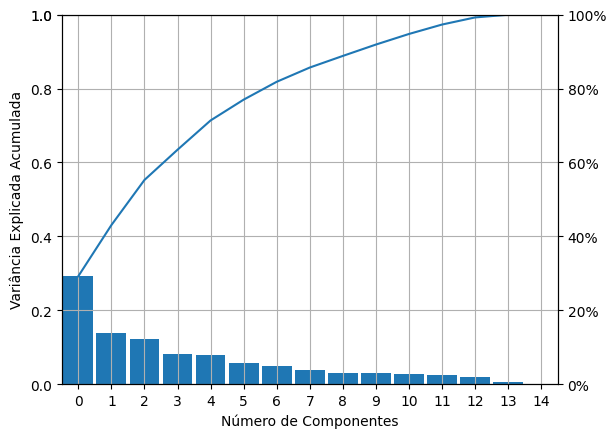

In [267]:
pca = PCA().fit(X_train_transf)

fig, ax = plt.subplots()
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
pareto(pca.explained_variance_ratio_)
ax.grid()
plt.show()

In [268]:
#Executando novamente com o número de componentes escolhido

pca = PCA(n_components=5).fit(X_train_transf)

X_train_pca = pca.transform(X_train_transf)
X_test_pca = pca.transform(X_test_transf)

In [269]:
pd.DataFrame(pca.components_.T, columns=['PC1','PC2','PC3','PC4','PC5'], index = preproc_pipeline_x.get_feature_names_out())

,PC1,PC2,PC3,PC4,PC5
impt__bmi,0.508058,0.138382,0.824184,0.004982,-0.010786
num__age,0.597679,-0.495976,-0.372127,-0.068788,-0.100794
num__avg_glucose_level,0.458984,0.752127,-0.382072,-0.063675,0.222718
cat__gender_Female,-0.021914,-0.149860,0.039734,-0.209794,0.615523
cat__gender_Male,0.021914,0.149860,-0.039734,0.209794,-0.615523
cat__hypertension_0,-0.089434,0.041207,0.055272,-0.018373,-0.027087
cat__hypertension_1,0.089434,-0.041207,-0.055272,0.018373,0.027087
cat__heart_disease_0,-0.064486,-0.033704,0.071723,0.012456,0.053668
cat__heart_disease_1,0.064486,0.033704,-0.071723,-0.012456,-0.053668
cat__ever_married_No,-0.225029,0.167783,0.019452,-0.048165,0.039175


## 2.Modelo de ML:  Desenvolver e treinar modelos de árvores de decisão para tarefas de classificação.

### Primeiro descobri o max_deth ideal

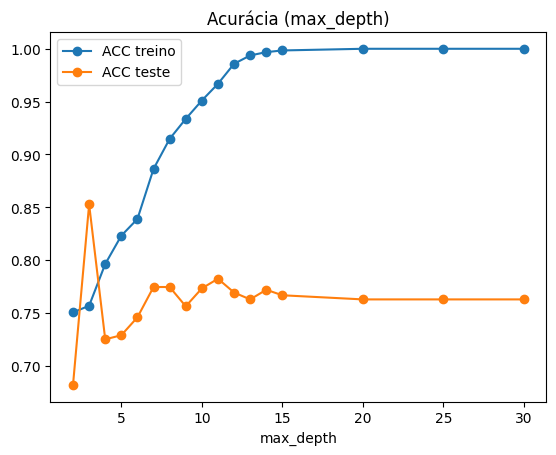

In [270]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

valor_depth = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,30]
train_yhat, train_acc,train_scores,test_yhat,test_acc,test_scores = [],[],[],[],[],[]

for d in valor_depth:
    clf = DecisionTreeClassifier(max_depth = d, random_state=40)
    clf = clf.fit(X_train_pca, Y_train)
    y_pred = pd.DataFrame(clf.predict(X_test_pca))

    #Avaliar score com dados de treino
    train_yhat = clf.predict(X_train_pca)
    train_acc = accuracy_score(Y_train, train_yhat)
    train_scores.append(train_acc)

    #Avaliar score com dados de teste
    test_yhat = clf.predict(X_test_pca)
    test_acc = accuracy_score(Y_test, test_yhat)
    test_scores.append(test_acc)

plt.plot(valor_depth, train_scores, '-o', label='ACC treino')
plt.plot(valor_depth, test_scores, '-o', label='ACC teste')
plt.xlabel('max_depth')
plt.title('Acurácia (max_depth)')
plt.legend()
plt.show()

### Depois utilizei o melhor max_depth identificado e testei com diferentes min_sample_split

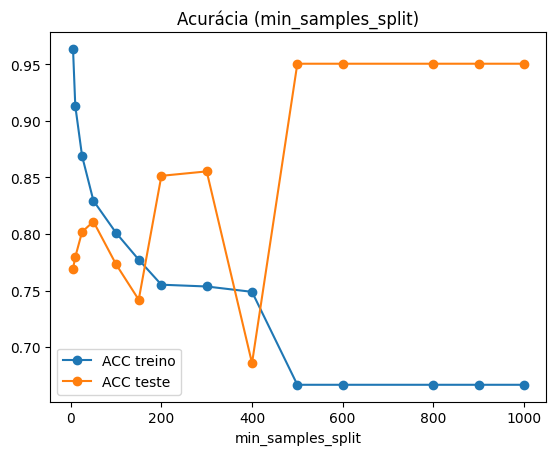

In [271]:
train_yhat, train_acc,train_scores,test_yhat,test_acc,test_scores = [],[],[],[],[],[]
min_samples_split = [5, 10, 25, 50, 100, 150, 200, 300, 400, 500, 600, 800, 900, 1000]


for i in min_samples_split:
    clf = DecisionTreeClassifier(min_samples_split = i, random_state=42)
    clf = clf.fit(X_train_pca, Y_train)
    y_pred = pd.DataFrame(clf.predict(X_test_pca))

    #Avaliar score com dados de treino
    train_yhat = clf.predict(X_train_pca)
    train_acc = accuracy_score(Y_train, train_yhat)
    train_scores.append(train_acc)

    #Avaliar score com dados de teste
    test_yhat = clf.predict(X_test_pca)
    test_acc = accuracy_score(Y_test, test_yhat)
    test_scores.append(test_acc)

plt.plot(min_samples_split, train_scores, '-o', label='ACC treino')
plt.plot(min_samples_split, test_scores, '-o', label='ACC teste')
plt.xlabel('min_samples_split')
plt.title('Acurácia (min_samples_split)')
plt.legend()
plt.show()

## 3.Avaliação de Modelos: Aplicar técnicas de validação cruzada para estimar a eficiência dos modelos desenvolvidos.

# e

## 4.Busca Hiperparamétrica: Utilizar GridSearch para otimizar os hiperparâmetros dos modelos.

# e

## 5.Pruning de Árvores de Decisão: Realizar o pruning (poda) em árvores de decisão para prevenir o overfitting e melhorar a generalização do modelo.

### Abaixo atendo às questões 3, 4 e 5 juntas

Agora aplico o CV e o Grid Search, já delimitando o range dos parãmetros em valores próximos aos identificados como ideais, reduzindo a quantidade de iterações.

In [284]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

clf = DecisionTreeClassifier()

parametros = {'criterion':['gini','entropy','log_loss'],
              'max_depth':[2,4,5,6,7,8,9,10],
              'min_samples_split': [25,50,100, 150, 200, 250, 300, 350, 400, 500, 750, 1000]}

model = GridSearchCV(DecisionTreeClassifier(), parametros, cv=5, refit=True, scoring='recall')

# Realizando o treino
model.fit(X_train_pca, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [25, 50, 100, 150, 200, 250, 300,
                                               350, 400, 500, 750, 1000]},
             scoring='recall')

In [285]:
best_estimator = model.best_estimator_
scores = cross_val_score(best_estimator, X_test_pca, Y_test, cv=5)

# Imprimindo os resultados
print("Melhores parâmetros:", model.best_params_)
print("Maior score da validação cruzada:", max(scores))
print("Média dos scores de validação cruzada:", np.mean(scores))

Melhores parâmetros: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 300}
Maior score da validação cruzada: 0.954248366013072
Média dos scores de validação cruzada: 0.9504626092861388


## 6.Avaliação de Classificadores Binários: Utilizar figuras de mérito como Curva ROC, precisão, recall, f1-score, sensibilidade e especificidade para avaliar os modelos.

In [290]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [292]:
Y_pred = pd.DataFrame(model.predict(X_test_pca))
print(classification_report(Y_test, Y_pred))
print('AUC = ', roc_auc_score(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.68      0.80       729
           1       0.12      0.82      0.20        38

    accuracy                           0.69       767
   macro avg       0.55      0.75      0.50       767
weighted avg       0.94      0.69      0.77       767

AUC =  0.7474009096816115


o código abaixo é apenas para criar uma matriz de confusão já com algumas anotações, facilitando a minha compreensão

In [288]:
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_cm(cm, titulo, legendas=["Teve Derrame(1)", "Não teve(0)"]):
    """
    Plota a matriz de confusão com legendas TN, FP, FN, TP.

    Parâmetros:
    cm (array-like): Matriz de confusão.
    legendas (list): Lista de rótulos personalizados para as classes.
    titulo (str): Título do gráfico.
    """

    # Inverter a posição das classes 0 e 1 na matriz de confusão
    cm = cm[::-1, ::-1]
    tp, fn, fp, tn = cm.ravel()

    # Plotar a matriz de confusão 
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=legendas)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)

    for text in disp.text_.ravel():
        text.set_visible(False)

    # Adicionar retângulos ilustrativos
    rect_v = Rectangle((-0.3, -0.29), 0.6, 1.5, linewidth=2, edgecolor='red', facecolor='none')
    rect_h = Rectangle((-0.32, -0.27), 1.72, 0.5, linewidth=2, edgecolor='blue', facecolor='none')
    ax.add_patch(rect_h)
    ax.add_patch(rect_v)

    # Mover rótulos das classes preditas para o topo
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    
    # Ajustar títulos dos eixos
    ax.set_title(titulo)
    ax.set_xlabel('Classe Predita')
    ax.set_ylabel('Classe Real')

    # Calcular Métricas
    total = tp + tn + fn + fp
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    accuracy_percent = accuracy * 100   
    precision_percent = precision * 100
    recall_percent = recall * 100

    # Adicionar legendas
    ax.text(0, -0.2, f'TP= {tp}', va='center', ha='center', color='black', fontsize=9, fontweight='bold')
    ax.text(0, -0.1, f'Acurácia:{accuracy_percent:.0f}%', va='center', ha='center', color='black', fontsize=9)
    ax.text(0, 0.0, f'Precisão:{precision_percent:.0f}%', va='center', ha='center', color='red', fontsize=9)
    ax.text(0, 0.1, f'Recall:{recall_percent:.0f}%', va='center', ha='center', color='blue', fontsize=9)

    ax.text(0, 1, f'FP= {fp} \n (Previ errado)', va='center', ha='center', color='black', fontsize=9, fontweight='bold')
    ax.text(1, 0, f'FN= {fn} \n (Deixei de prever)', va='center', ha='center', color='black', fontsize=9, fontweight='bold')
    ax.text(1, 1, f'TN= {tn}', va='center', ha='center', color='black', fontsize=9, fontweight='bold')

    # Adicionar anotações abaixo do gráfico
    accuracy_text = f"Acurácia = (TP + TN) / TOTAL = ({tp}+{tn}) / {total} = {accuracy_percent:.2f}%"
    precision_text = f"Precisão = TP / (TP + FP) = {tp} / ({tp}+{fp}) = {precision_percent:.2f}%"
    recall_text = f"Recall = TP / (TP + FN) = {tp} / ({tp}+{fn}) = {recall_percent:.2f}%"

    plt.figtext(0.22, -0, accuracy_text, wrap=True, horizontalalignment='left', fontsize=9, color='black')
    plt.figtext(0.22, -0.05, precision_text, wrap=True, horizontalalignment='left', fontsize=9, color='red')
    plt.figtext(0.22, -0.1, recall_text, wrap=True, horizontalalignment='left', fontsize=9, color='blue')

    plt.show()

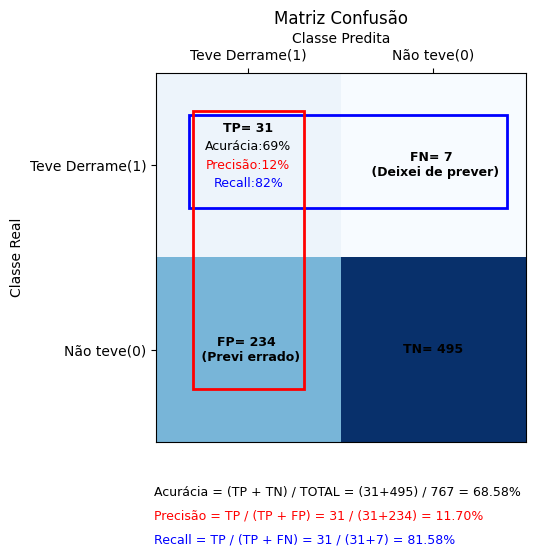

In [289]:
cm= metrics.confusion_matrix(Y_test, Y_pred)
plot_cm(cm, titulo = 'Matriz Confusão')

## 7.Baseado nos valores encontrados para as diferentes figuras de mérito, interprete os resultados e disserte sobre a eficiência do classificador criado.

Devido ao desbalanceamento da classe positiva, se torna um dataset difícil para realizar a predição, tendo de escolher entre ter uma boa Precisão ou um bom Recall. Dado o objeto de estudo, escolhi por ter um bom Recall, conseguindo identificar qualquer pessoa com risco de ter um derrame, mesmo que nesse processo acabe por ser alarmista, tendo uma grande quantidade de Falso Posivos.

Após a aplicação da técnica de Undersampling nos dados de treino, consegui chegar a um Recall de 82%, o que entendi como muito satisfatório.
Ainda assim, a quantidade de amostras do target positivo (pessoas que tiveram derrame) é de apenas 249, quantidade muito baixa para dizermos que o modelo é confiável. Em um cenário real, deveríamos continuar a coletar amostras para aumentar os dados de treino.